In [1]:
# ==========================================
# 1. IMPORTS & CONFIGURATION
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Dropout
)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

2025-12-26 17:24:16.447753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766769856.910522      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766769857.027787      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766769858.214525      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766769858.214572      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766769858.214575      24 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"✅ Success! TensorFlow is using {len(gpus)} GPU(s).")
    for gpu in gpus:
        print(f"   Device: {gpu.name}")
        # Optional: Set memory growth to prevent OOM errors
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
else:
    print("❌ Still no GPU found. Please check the 'Accelerator' setting in the sidebar.")

✅ Success! TensorFlow is using 2 GPU(s).
   Device: /physical_device:GPU:0
   Device: /physical_device:GPU:1


In [3]:
# ==========================================
# CONFIGURATION (UPDATED FOR INCEPTION V3)
# ==========================================
# InceptionV3 requires a minimum of 75x75. 
# We use 150x150 to preserve feature quality from the 48x48 originals without too much blurring.
IMG_WIDTH, IMG_HEIGHT = 150, 150 
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 7
CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [4]:
# ==========================================
# 2. DATA LOADING
# ==========================================
def get_dataset_paths():
    """Auto-detects the correct path for msambare/fer2013 dataset"""
    possible_roots = [
        '/kaggle/input/fer2013',
        '/kaggle/input/fer2013/fer2013'
    ]
    for root in possible_roots:
        train_path = os.path.join(root, 'train')
        test_path = os.path.join(root, 'test')
        if os.path.exists(train_path) and os.path.exists(test_path):
            print(f"✅ Dataset found at: {root}")
            return train_path, test_path
    raise FileNotFoundError("Could not find 'train' and 'test' folders in standard Kaggle paths.")

train_dir, test_dir = get_dataset_paths()

✅ Dataset found at: /kaggle/input/fer2013


In [5]:
# ==========================================
# 3. DATA AUGMENTATION & GENERATORS
# ==========================================
# Training Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # Increased slightly for the larger model
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation Generator
test_datagen = ImageDataGenerator(rescale=1./255)

print("\n--- Setting up Data Generators ---")

# NOTE: We change color_mode to 'rgb' because InceptionV3 expects 3 channels.
# We change target_size to (150, 150) to satisfy InceptionV3 spatial requirements.

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",         # Changed from grayscale
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_LABELS,
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",         # Changed from grayscale
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_LABELS,
    shuffle=False
)


--- Setting up Data Generators ---
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# ==========================================
# 4. MODEL ARCHITECTURE (InceptionV3) - UPDATED
# ==========================================
def build_inception_model(input_shape=(150, 150, 3), num_classes=7):
    # Load InceptionV3 with ImageNet weights, exclude top (classification) layers
    base_model = InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # ----------------------------------------------------
    # CHANGE: Unfreeze more layers for deeper fine-tuning 
    # (Unfreezing the last ~100 layers instead of ~50)
    # ----------------------------------------------------
    for layer in base_model.layers[:-100]: 
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    
    # ----------------------------------------------------
    # CHANGE: Lower Dropout Rate for better feature retention
    # ----------------------------------------------------
    x = Dropout(0.4)(x) # Changed from 0.5
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs, name="FER_InceptionV3_Tuned")
    return model

model = build_inception_model()
# model.summary() # Run this to see which layers are trainable (now 100+)

I0000 00:00:1766769891.403279      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766769891.407351      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# ==========================================
# 5. TRAINING (REVISED TO RUN ALL 50 EPOCHS)
# ==========================================
# --- 1. Dataset Conversion for Parallelism (Using previous implementation) ---
def generator_to_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(None, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, NUM_CLASSES), dtype=tf.float32)
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=output_signature
    )
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Convert the generators into high-performance datasets
train_dataset = generator_to_dataset(train_generator)
validation_dataset = generator_to_dataset(validation_generator)

# Using the improved InceptionV3 model from the previous step
model.compile(
    # Lowered LR for deeper fine-tuning
    optimizer=Adam(learning_rate=0.00005), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, # Using patience=5 from previous recommendation
    min_lr=1e-7,
    verbose=1
)

# NOTE: EarlyStopping is REMOVED from the callbacks list below.
checkpoint = ModelCheckpoint(
    # Ensure this is the correct path for the best model weights
    'fer2013_emotion_model_v2.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

print("\nStarting Training (Running for full 50 epochs)...")

# Calculate steps needed to run through the entire dataset once
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

# --- 2. Training Call with Dataset ---
history = model.fit(
    train_dataset,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=EPOCHS, # Will run the full 50 epochs
    validation_data=validation_dataset,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[lr_scheduler, checkpoint] # EarlyStopping is removed
)


Starting Training (Running for full 50 epochs)...
Epoch 1/50


I0000 00:00:1766769912.228290      84 service.cc:152] XLA service 0x79fa6c005600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766769912.228334      84 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766769912.228340      84 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766769916.466712      84 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:54:36 40s/step - accuracy: 0.1562 - loss: 2.1310

I0000 00:00:1766769935.320073      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.3211 - loss: 1.7199
Epoch 1: val_accuracy improved from -inf to 0.49400, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 406s 820ms/step - accuracy: 0.3212 - loss: 1.7196 - val_accuracy: 0.4940 - val_loss: 1.3197 - learning_rate: 5.0000e-05
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4814 - loss: 1.3632
Epoch 2: val_accuracy improved from 0.49400 to 0.52797, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 246s 508ms/step - accuracy: 0.4815 - loss: 1.3631 - val_accuracy: 0.5280 - val_loss: 1.2376 - learning_rate: 5.0000e-05
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.5276 - loss: 1.2466
Epoch 3: val_accuracy improved from 0.52797 to 0.55763, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 203s 454ms/step - accuracy: 0.5276 - loss: 1.2466 - val_accuracy: 0.5576 - val_loss: 1.1652 - learning_rate: 5.0000e-05
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5564 - loss: 1.1838
Epoch 4: val_accuracy improved from 0.55763 to 0.57366, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 192s 429ms/step - accuracy: 0.5564 - loss: 1.1838 - val_accuracy: 0.5737 - val_loss: 1.1286 - learning_rate: 5.0000e-05
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.5670 - loss: 1.1412
Epoch 5: val_accuracy improved from 0.57366 to 0.59095, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 187s 419ms/step - accuracy: 0.5670 - loss: 1.1411 - val_accuracy: 0.5909 - val_loss: 1.0917 - learning_rate: 5.0000e-05
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.5934 - loss: 1.0808
Epoch 6: val_accuracy improved from 0.59095 to 0.60191, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 199s 445ms/step - accuracy: 0.5934 - loss: 1.0808 - val_accuracy: 0.6019 - val_loss: 1.0684 - learning_rate: 5.0000e-05
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.6091 - loss: 1.0424
Epoch 7: val_accuracy did not improve from 0.60191
448/448 ━━━━━━━━━━━━━━━━━━━━ 190s 426ms/step - accuracy: 0.6091 - loss: 1.0425 - val_accuracy: 0.6019 - val_loss: 1.0572 - learning_rate: 5.0000e-05
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6191 - loss: 1.0149
Epoch 8: val_accuracy improved from 0.60191 to 0.60655, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 178s 397ms/step - accuracy: 0.6192 - loss: 1.0149 - val_accuracy: 0.6066 - val_loss: 1.0586 - learning_rate: 5.0000e-05
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6498 - loss: 0.9604
Epoch 9: val_accuracy did not improve from 0.60655
448/448 ━━━━━━━━━━━━━━━━━━━━ 176s 393ms/step - accuracy: 0.6498 - loss: 0.9605 - val_accuracy: 0.6029 - val_loss: 1.0684 - learning_rate: 5.0000e-05
Epoch 10/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.6515 - loss: 0.9395
Epoch 10: val_accuracy improved from 0.60655 to 0.61892, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 178s 398ms/step - accuracy: 0.6515 - loss: 0.9395 - val_accuracy: 0.6189 - val_loss: 1.0529 - learning_rate: 5.0000e-05
Epoch 11/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6614 - loss: 0.9051
Epoch 11: val_accuracy improved from 0.61892 to 0.62609, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 174s 389ms/step - accuracy: 0.6614 - loss: 0.9051 - val_accuracy: 0.6261 - val_loss: 1.0346 - learning_rate: 5.0000e-05
Epoch 12/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6765 - loss: 0.8684
Epoch 12: val_accuracy did not improve from 0.62609
448/448 ━━━━━━━━━━━━━━━━━━━━ 176s 393ms/step - accuracy: 0.6765 - loss: 0.8684 - val_accuracy: 0.6230 - val_loss: 1.0729 - learning_rate: 5.0000e-05
Epoch 13/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6874 - loss: 0.8471
Epoch 13: val_accuracy improved from 0.62609 to 0.62862, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 172s 385ms/step - accuracy: 0.6874 - loss: 0.8471 - val_accuracy: 0.6286 - val_loss: 1.0556 - learning_rate: 5.0000e-05
Epoch 14/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6963 - loss: 0.8265
Epoch 14: val_accuracy did not improve from 0.62862
448/448 ━━━━━━━━━━━━━━━━━━━━ 174s 389ms/step - accuracy: 0.6964 - loss: 0.8265 - val_accuracy: 0.6216 - val_loss: 1.0795 - learning_rate: 5.0000e-05
Epoch 15/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7084 - loss: 0.7925
Epoch 15: val_accuracy did not improve from 0.62862
448/448 ━━━━━━━━━━━━━━━━━━━━ 171s 382ms/step - accuracy: 0.7083 - loss: 0.7925 - val_accuracy: 0.6283 - val_loss: 1.0851 - learning_rate: 5.0000e-05
Epoch 16/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7132 - loss: 0.7667
Epoch 16: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 16: val_accuracy improved from 0.62862 to 0.63256, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 184s 411ms/step - accuracy: 0.7132 - loss: 0.7667 - val_accuracy: 0.6326 - val_loss: 1.0912 - learning_rate: 5.0000e-05
Epoch 17/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7351 - loss: 0.7329
Epoch 17: val_accuracy did not improve from 0.63256
448/448 ━━━━━━━━━━━━━━━━━━━━ 178s 398ms/step - accuracy: 0.7351 - loss: 0.7329 - val_accuracy: 0.6321 - val_loss: 1.1000 - learning_rate: 2.5000e-05
Epoch 18/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7476 - loss: 0.6871
Epoch 18: val_accuracy improved from 0.63256 to 0.63916, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 170s 380ms/step - accuracy: 0.7476 - loss: 0.6871 - val_accuracy: 0.6392 - val_loss: 1.1113 - learning_rate: 2.5000e-05
Epoch 19/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.7629 - loss: 0.6536
Epoch 19: val_accuracy improved from 0.63916 to 0.64661, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 175s 392ms/step - accuracy: 0.7629 - loss: 0.6537 - val_accuracy: 0.6466 - val_loss: 1.1307 - learning_rate: 2.5000e-05
Epoch 20/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7681 - loss: 0.6393
Epoch 20: val_accuracy did not improve from 0.64661
448/448 ━━━━━━━━━━━━━━━━━━━━ 176s 393ms/step - accuracy: 0.7681 - loss: 0.6393 - val_accuracy: 0.6421 - val_loss: 1.1284 - learning_rate: 2.5000e-05
Epoch 21/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7664 - loss: 0.6360
Epoch 21: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 21: val_accuracy did not improve from 0.64661
448/448 ━━━━━━━━━━━━━━━━━━━━ 177s 395ms/step - accuracy: 0.7664 - loss: 0.6360 - val_accuracy: 0.6414 - val_loss: 1.1624 - learning_rate: 2.5000e-05
Epoch 22/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7790 - loss: 0.6105
Epoch 22: val_accuracy improved from 0.64661 to 0.64675, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 179s 400ms/step - accuracy: 0.7790 - loss: 0.6105 - val_accuracy: 0.6468 - val_loss: 1.1595 - learning_rate: 1.2500e-05
Epoch 23/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7839 - loss: 0.6001
Epoch 23: val_accuracy improved from 0.64675 to 0.64746, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 170s 381ms/step - accuracy: 0.7839 - loss: 0.6000 - val_accuracy: 0.6475 - val_loss: 1.1690 - learning_rate: 1.2500e-05
Epoch 24/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7882 - loss: 0.5725
Epoch 24: val_accuracy did not improve from 0.64746
448/448 ━━━━━━━━━━━━━━━━━━━━ 167s 374ms/step - accuracy: 0.7882 - loss: 0.5725 - val_accuracy: 0.6459 - val_loss: 1.1718 - learning_rate: 1.2500e-05
Epoch 25/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7913 - loss: 0.5668
Epoch 25: val_accuracy improved from 0.64746 to 0.64774, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 168s 376ms/step - accuracy: 0.7913 - loss: 0.5668 - val_accuracy: 0.6477 - val_loss: 1.1753 - learning_rate: 1.2500e-05
Epoch 26/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7976 - loss: 0.5534
Epoch 26: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 26: val_accuracy did not improve from 0.64774
448/448 ━━━━━━━━━━━━━━━━━━━━ 164s 367ms/step - accuracy: 0.7976 - loss: 0.5534 - val_accuracy: 0.6461 - val_loss: 1.1900 - learning_rate: 1.2500e-05
Epoch 27/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8053 - loss: 0.5383
Epoch 27: val_accuracy improved from 0.64774 to 0.64844, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 177s 396ms/step - accuracy: 0.8053 - loss: 0.5382 - val_accuracy: 0.6484 - val_loss: 1.2029 - learning_rate: 6.2500e-06
Epoch 28/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8009 - loss: 0.5453
Epoch 28: val_accuracy did not improve from 0.64844
448/448 ━━━━━━━━━━━━━━━━━━━━ 192s 429ms/step - accuracy: 0.8009 - loss: 0.5453 - val_accuracy: 0.6472 - val_loss: 1.2113 - learning_rate: 6.2500e-06
Epoch 29/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8092 - loss: 0.5233
Epoch 29: val_accuracy improved from 0.64844 to 0.64985, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 173s 387ms/step - accuracy: 0.8092 - loss: 0.5233 - val_accuracy: 0.6498 - val_loss: 1.2101 - learning_rate: 6.2500e-06
Epoch 30/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8058 - loss: 0.5214
Epoch 30: val_accuracy did not improve from 0.64985
448/448 ━━━━━━━━━━━━━━━━━━━━ 172s 384ms/step - accuracy: 0.8058 - loss: 0.5214 - val_accuracy: 0.6497 - val_loss: 1.2176 - learning_rate: 6.2500e-06
Epoch 31/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8097 - loss: 0.5137
Epoch 31: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 31: val_accuracy improved from 0.64985 to 0.65420, saving model to fer2013_emotion_model_v2.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 180s 401ms/step - accuracy: 0.8097 - loss: 0.5137 - val_accuracy: 0.6542 - val_loss: 1.2201 - learning_rate: 6.2500e-06
Epoch 32/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8131 - loss: 0.5191
Epoch 32: val_accuracy did not improve from 0.65420
448/448 ━━━━━━━━━━━━━━━━━━━━ 170s 380ms/step - accuracy: 0.8131 - loss: 0.5191 - val_accuracy: 0.6507 - val_loss: 1.2198 - learning_rate: 3.1250e-06
Epoch 33/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8174 - loss: 0.5043
Epoch 33: val_accuracy did not improve from 0.65420
448/448 ━━━━━━━━━━━━━━━━━━━━ 169s 378ms/step - accuracy: 0.8174 - loss: 0.5043 - val_accuracy: 0.6505 - val_loss: 1.2252 - learning_rate: 3.1250e-06
Epoch 34/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8216 - loss: 0.4928
Epoch 34: val_accuracy did not improve from 0.65420
448/448 ━━━━━━━━━━━━━━━━━━━━ 177s 397ms/step - accuracy: 0.8216 - loss: 0.4928 - val_accuracy: 0.6493 - val_loss: 1.2319 - learnin

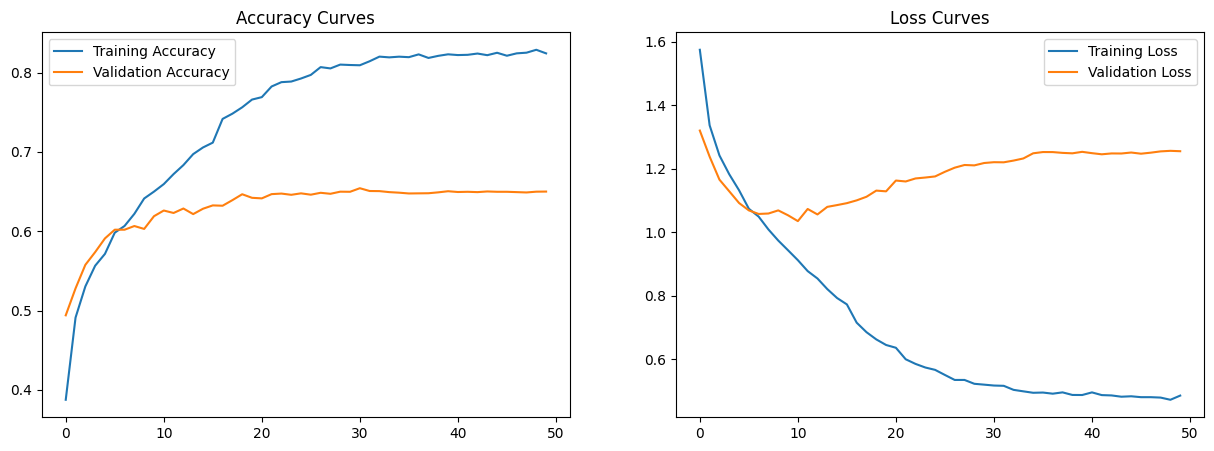

Evaluating on Test Set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - accuracy: 0.6098 - loss: 1.3902

Final Validation Accuracy: 65.20%
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step


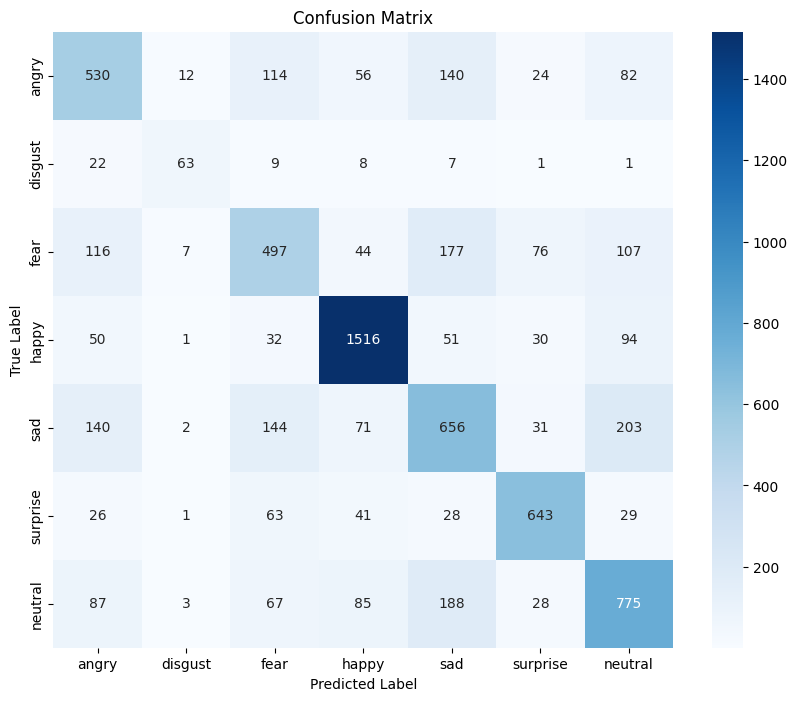


Classification Report:

              precision    recall  f1-score   support

       angry       0.55      0.55      0.55       958
     disgust       0.71      0.57      0.63       111
        fear       0.54      0.49      0.51      1024
       happy       0.83      0.85      0.84      1774
         sad       0.53      0.53      0.53      1247
    surprise       0.77      0.77      0.77       831
     neutral       0.60      0.63      0.61      1233

    accuracy                           0.65      7178
   macro avg       0.65      0.63      0.64      7178
weighted avg       0.65      0.65      0.65      7178



In [8]:
# ==========================================
# 6. EVALUATION
# ==========================================
# 1. Plotting Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# 2. Final Evaluation on Test Set
print("Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(validation_generator)
print(f"\nFinal Validation Accuracy: {test_acc*100:.2f}%")

# 3. Confusion Matrix
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = validation_generator.classes

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_LABELS, 
            yticklabels=CLASS_LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_LABELS))

In [9]:
# ==========================================
# 7. SAVING
# ==========================================
save_path = '/kaggle/working/fer2013_emotion_model_final.h5'
model.save(save_path)

if os.path.exists(save_path):
    print(f"✅ Success! Model saved at: {save_path}")
    print(f"File Size: {os.path.getsize(save_path) / (1024 * 1024):.2f} MB")
else:
    print("❌ Error: Model was not saved.")

print("\nCurrent files in /kaggle/working/ :")
print(os.listdir('/kaggle/working/'))

✅ Success! Model saved at: /kaggle/working/fer2013_emotion_model_final.h5
File Size: 212.20 MB

Current files in /kaggle/working/ :
['__notebook__.ipynb', 'fer2013_emotion_model_final.h5', 'fer2013_emotion_model_v2.h5']
